In [1]:
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import fermi_surface as fs
importlib.reload(fs)
import density_of_states as dos
importlib.reload(dos);

### Koeffizientenfunktionen

In [2]:
def f_i_linear(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    return k[..., i-1]

def df_i_linear(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., i-1] = 1.0
    return d

def ddf_i_linear(k, i):
    return np.zeros(np.shape(k) + (np.shape(k)[-1],))

def f_i_exp(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    if i % 2 == 1:
        return np.cos(k[..., (i-1)//2])
    else:
        return np.sin(k[..., (i-1)//2])

def df_i_exp(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.sin(k[..., (i-1)//2])[:,None] * d
    else:
        return np.cos(k[..., (i-1)//2])[:,None] * d

def ddf_i_exp(k, i):
    assert i >= 0
    d = np.zeros(np.shape(k) + (np.shape(k)[-1],))
    if i == 0:
        return d
    d[..., (i-1)//2, (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.cos(k[..., (i-1)//2])[:,None,None] * d
    else:
        return -np.sin(k[..., (i-1)//2])[:,None,None] * d

### Symmetrisierte Koeffizienten

In [7]:
neighbor_R = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (2, 2, 2), (3, 0, 0)) # works well
neighbor_R = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0))
f_i_sym, df_i_sym, term_count, neighbor_R = get_tight_binding_coeff_funcs(Symmetry.cubic(True), np.eye(3), neighbor_R)

# Tests

[[[-2.121-0.j     0.   +0.j   ]
  [ 0.   -0.j     2.132+0.j   ]]

 [[-0.604+0.j     1.556+0.j   ]
  [ 1.556-0.j     1.629+0.j   ]]

 [[-1.377-0.j    -0.19 +1.182j]
  [-0.19 -1.182j  1.122-0.j   ]]]
loss: 3.95e-01
loss: 1.00e-01
loss: 1.92e-02
loss: 3.02e-03
loss: 3.89e-04
loss: 9.69e-05
loss: 1.59e-05
loss: 2.98e-06
loss: 9.88e-07
loss: 2.72e-07
final loss: 7.64378822509666e-08
[[[-2.121+0.j    -0.   +0.j   ]
  [ 0.   +0.j     2.132-0.j   ]]

 [[-0.604+0.j     1.556+0.j   ]
  [ 1.556-0.j     1.629-0.j   ]]

 [[-1.377+0.j    -0.19 +1.183j]
  [-0.19 -1.183j  1.122-0.j   ]]]


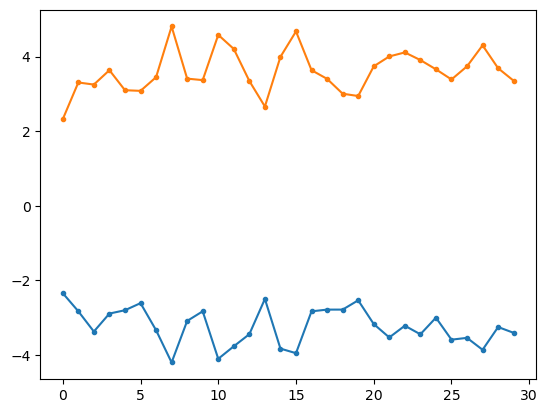

In [4]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])
tb2_ref.normalize()
print(tb2_ref.params)

#k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)
k_smpl = np.random.random((30, 2))

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

In [5]:
# test gradients
tb2 = BandStructureModel(f_i_exp, df_i_exp,
                        [random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6)], ddf_i_exp)
tb2.normalize()

h = 1e-6
k_smpl = np.random.random((30, 3))
dx = np.reshape((h, 0, 0), (1, -1))
dy = np.reshape((0, h, 0), (1, -1))
dz = np.reshape((0, 0, h), (1, -1))

# test gradients
bands, grads = tb2.bands_grad(k_smpl)
bandsx = tb2.bands(k_smpl + dx)
bandsy = tb2.bands(k_smpl + dy)
bandsz = tb2.bands(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(bands + (grads * dx.reshape(1,-1,1)).sum(1) - bandsx) / h**2)
print(np.linalg.norm(bands + (grads * dy.reshape(1,-1,1)).sum(1) - bandsy) / h**2)
print(np.linalg.norm(bands + (grads * dz.reshape(1,-1,1)).sum(1) - bandsz) / h**2)

# test hessians
k_smpl = np.random.random((30, 3))
bands, grads, hess = tb2.bands_grad_hess(k_smpl)
#print(np.linalg.norm(hess, axis=(0, -1)))
bandsx, gradsx = tb2.bands_grad(k_smpl + dx)
bandsy, gradsy = tb2.bands_grad(k_smpl + dy)
bandsz, gradsz = tb2.bands_grad(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(grads + hess[:,:,0]*h - gradsx, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,1]*h - gradsy, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,2]*h - gradsz, axis=(0,2)) / h**2)


21.527441197316698
8.609551155551516
18.7448651668951
[120.632  36.29   45.972]
[34.859 42.1   14.866]
[49.259 30.533 81.509]


[[[-3.487+0.j    -0.   -0.j     0.   -0.j   ]
  [-0.   +0.j    -1.216+0.j     0.   -0.j   ]
  [-0.   +0.j     0.   +0.j     2.394+0.j   ]]

 [[-0.094+0.j     0.553+0.j     1.022-0.146j]
  [ 0.553+0.j     0.933-0.j     0.955+0.j   ]
  [ 1.022+0.146j  0.955+0.j     0.161+0.j   ]]]
loss: 8.33e-02
loss: 3.05e-02
loss: 1.31e-03
loss: 1.83e-04
loss: 1.13e-05
loss: 6.83e-07
loss: 8.69e-08
loss: 3.69e-09
loss: 4.09e-10
loss: 3.30e-11
final loss: 2.934187508974308e-12
[[[-3.487-0.j    -0.   -0.j     0.   +0.j   ]
  [ 0.   -0.j    -1.216+0.j    -0.   -0.j   ]
  [-0.   -0.j     0.   -0.j     2.394-0.j   ]]

 [[-0.094+0.j     0.813+0.j     0.114+0.365j]
  [ 0.813-0.j     0.933+0.j     1.215-0.j   ]
  [ 0.114-0.365j  1.215-0.j     0.161-0.j   ]]]


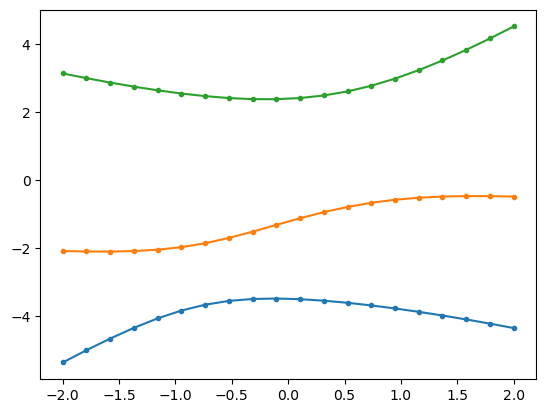

In [6]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])
tb2_ref.normalize()
print(tb2_ref.params)

k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

[[[-3.47 -0.j    -0.   +0.j    -0.   +0.j   ]
  [-0.   -0.j    -0.596+0.j    -0.   -0.j   ]
  [-0.   -0.j    -0.   +0.j     2.189+0.j   ]]

 [[ 0.479+0.j     1.103+0.j    -0.383+0.049j]
  [ 1.103+0.j     2.129+0.j     0.736+0.j   ]
  [-0.383-0.049j  0.736-0.j    -1.063-0.j   ]]]
loss: 7.11e-01
loss: 7.52e-01
loss: 2.79e-01
loss: 7.23e-02
loss: 7.18e-02
loss: 6.40e-02
loss: 5.00e-02
loss: 2.00e-02
loss: 1.22e-02
loss: 5.98e-03
loss: 2.97e-03
loss: 1.87e-03
loss: 8.16e-04
loss: 7.25e-04
loss: 5.76e-04
loss: 4.43e-04
loss: 1.81e-04
loss: 1.38e-04
loss: 1.04e-04
loss: 5.97e-05
final loss: 1.9785169024468197e-05
[[[-3.47 -0.j     0.   +0.j     0.   -0.j   ]
  [ 0.   -0.j    -0.596+0.j     0.   -0.j   ]
  [-0.   -0.j     0.   -0.j     2.189-0.j   ]]

 [[ 0.479-0.j     1.102-0.j    -0.382-0.058j]
  [ 1.102-0.j     2.129-0.j     0.736+0.j   ]
  [-0.382+0.058j  0.736-0.j    -1.063+0.j   ]]]


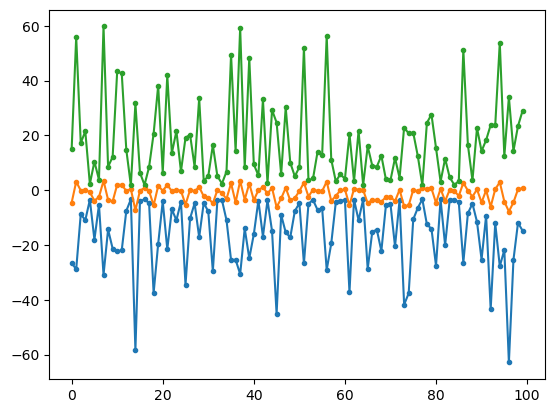

In [6]:
# NOTE The following does sometimes not converge for unknown reasons!!!
tb2 = BandStructureModel(f_i_sym, df_i_sym,
                        [random_hermitian(3),
                         random_hermitian(3)])

tb2_ref = BandStructureModel(f_i_sym, df_i_sym,
                        [random_hermitian(3),
                         random_hermitian(3)])
tb2_ref.normalize()
print(tb2_ref.params)

k_smpl = np.random.random((100, 3))

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1, 1], 0, 2000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

# Real Data

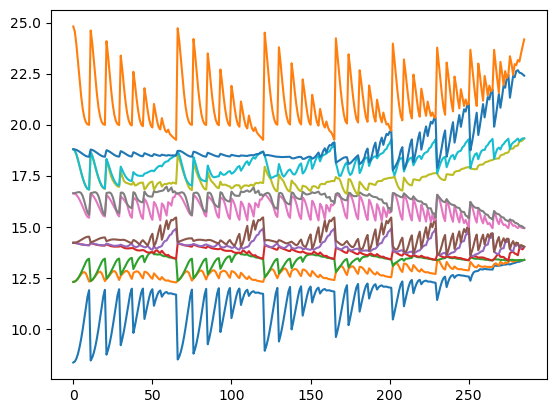

In [4]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
plot_bands_generic(k_smpl, ref_bands, '-')

loss: 4.29e-02
loss: 2.80e-02
loss: 1.47e-02
loss: 9.60e-03
loss: 8.17e-03
loss: 7.19e-03
loss: 6.81e-03
loss: 6.61e-03
loss: 6.56e-03
loss: 6.48e-03
loss: 6.43e-03
loss: 6.39e-03
loss: 6.36e-03
loss: 6.33e-03
loss: 6.30e-03
loss: 6.27e-03
loss: 6.25e-03
loss: 6.23e-03
loss: 6.21e-03
loss: 6.19e-03


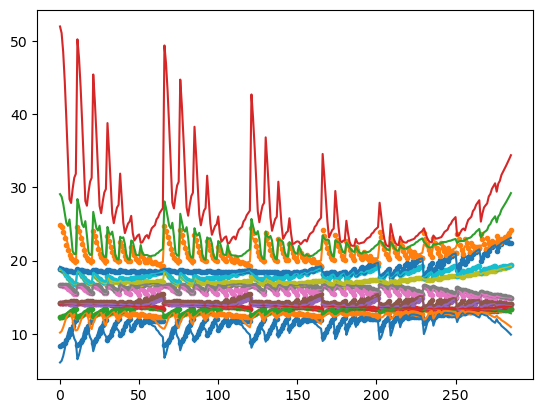

In [8]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]

# now start my algorithm to find good matrices
additional_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.005
weights[1] = 0.005
weights[2] = 0.05
weights[3] = 0.5
weights[-1] = 0.005
weights[-2] = 0.05
weights[-3] = 0.5

tb_nitinol = BandStructureModel.init_from_ref(f_i_sym, df_i_sym, term_count, ref_bands, band_offset, additional_bands)
tb_nitinol.normalize()
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 2000, 4)

plot_bands_generic(k_smpl, ref_bands, '.')
tb_nitinol.plot_bands(k_smpl)

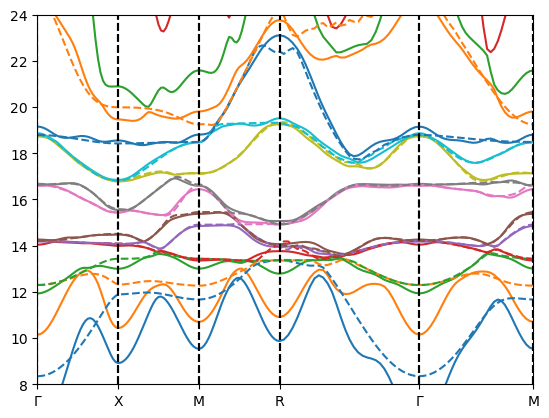

In [9]:
import kpaths
path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [10]:
bands_map = { tuple(np.round(k, 4)): np.round(bands, 4)  for k, bands in zip(k_smpl, all_ref_bands)}
print(bands_map.keys())
bands = bands_map[(-0.5,-0.5,-0.5)]
#bands = bands_map[(0,0,0)]
print(bands)
# count degeneracies
unique = set(bands)
print("unique values:", len(unique))
print("1-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 1]))
print("2-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 2]))
print("3-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 3]))

dict_keys([(0.0, 0.0, 0.0), (0.0, 0.0, 0.05), (0.0, 0.0, 0.1), (0.0, 0.0, 0.15), (0.0, 0.0, 0.2), (0.0, 0.0, 0.25), (0.0, 0.0, 0.3), (0.0, 0.0, 0.35), (0.0, 0.0, 0.4), (0.0, 0.0, 0.45), (0.0, 0.0, -0.5), (0.0, 0.05, 0.05), (0.0, 0.05, 0.1), (0.0, 0.05, 0.15), (0.0, 0.05, 0.2), (0.0, 0.05, 0.25), (0.0, 0.05, 0.3), (0.0, 0.05, 0.35), (0.0, 0.05, 0.4), (0.0, 0.05, 0.45), (0.0, 0.05, -0.5), (0.0, 0.1, 0.1), (0.0, 0.1, 0.15), (0.0, 0.1, 0.2), (0.0, 0.1, 0.25), (0.0, 0.1, 0.3), (0.0, 0.1, 0.35), (0.0, 0.1, 0.4), (0.0, 0.1, 0.45), (0.0, 0.1, -0.5), (0.0, 0.15, 0.15), (0.0, 0.15, 0.2), (0.0, 0.15, 0.25), (0.0, 0.15, 0.3), (0.0, 0.15, 0.35), (0.0, 0.15, 0.4), (0.0, 0.15, 0.45), (0.0, 0.15, -0.5), (0.0, 0.2, 0.2), (0.0, 0.2, 0.25), (0.0, 0.2, 0.3), (0.0, 0.2, 0.35), (0.0, 0.2, 0.4), (0.0, 0.2, 0.45), (0.0, 0.2, -0.5), (0.0, 0.25, 0.25), (0.0, 0.25, 0.3), (0.0, 0.25, 0.35), (0.0, 0.25, 0.4), (0.0, 0.25, 0.45), (0.0, 0.25, -0.5), (0.0, 0.3, 0.3), (0.0, 0.3, 0.35), (0.0, 0.3, 0.4), (0.0, 0.3, 0.45)

In [11]:
for i, (r, mat) in enumerate(zip(neighbor_R + neighbor_R, tb_nitinol.params)):
    print(r, np.linalg.norm(mat) * tb_nitinol.f_i((0, 0, 0), i), "real" if np.linalg.norm(np.imag(mat)) < 1e-8 else "complex")

[0. 0. 0.] 63.09701646248746 real
[2. 0. 0.] 10.44187319056703 complex
[2. 2. 0.] 9.884200560867436 complex
[2. 2. 2.] 5.675127905613349 complex
[4. 0. 0.] 4.639283220840904 complex
[4. 2. 0.] 7.631194186189985 complex
[4. 2. 2.] 6.665451185019089 complex
[4. 4. 2.] 6.479710263978566 complex
[4. 4. 4.] 3.581241860008269 complex
[6. 0. 0.] 4.793751525896031 complex


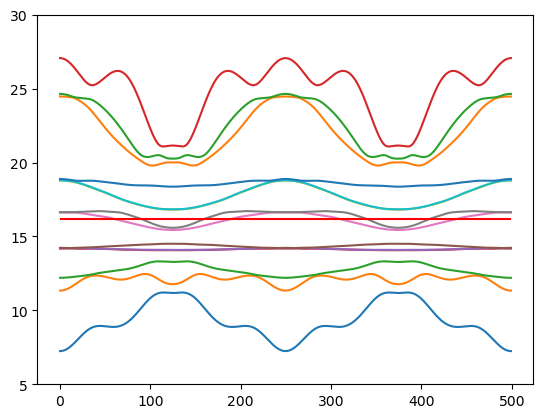

In [12]:
fermi_energy = 16.157
k_smpl = np.linspace(0, 2, 500).reshape(-1, 1) * [[1, 0, 0]]
tb_nitinol.plot_bands(k_smpl)
plt.hlines(fermi_energy, 0, len(k_smpl)-1, 'r')
plt.ylim(5, 30)
plt.show()

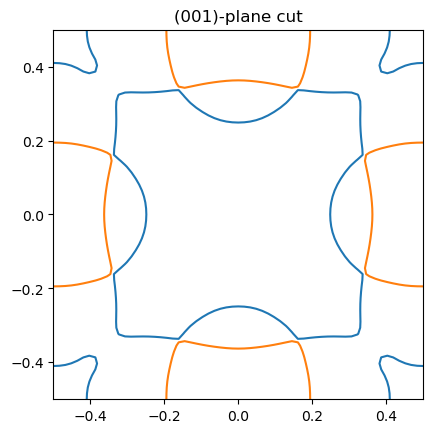

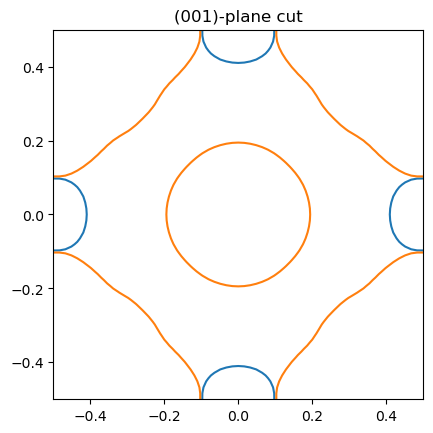

In [6]:
importlib.reload(fs)
fermi_energy = 16.157
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

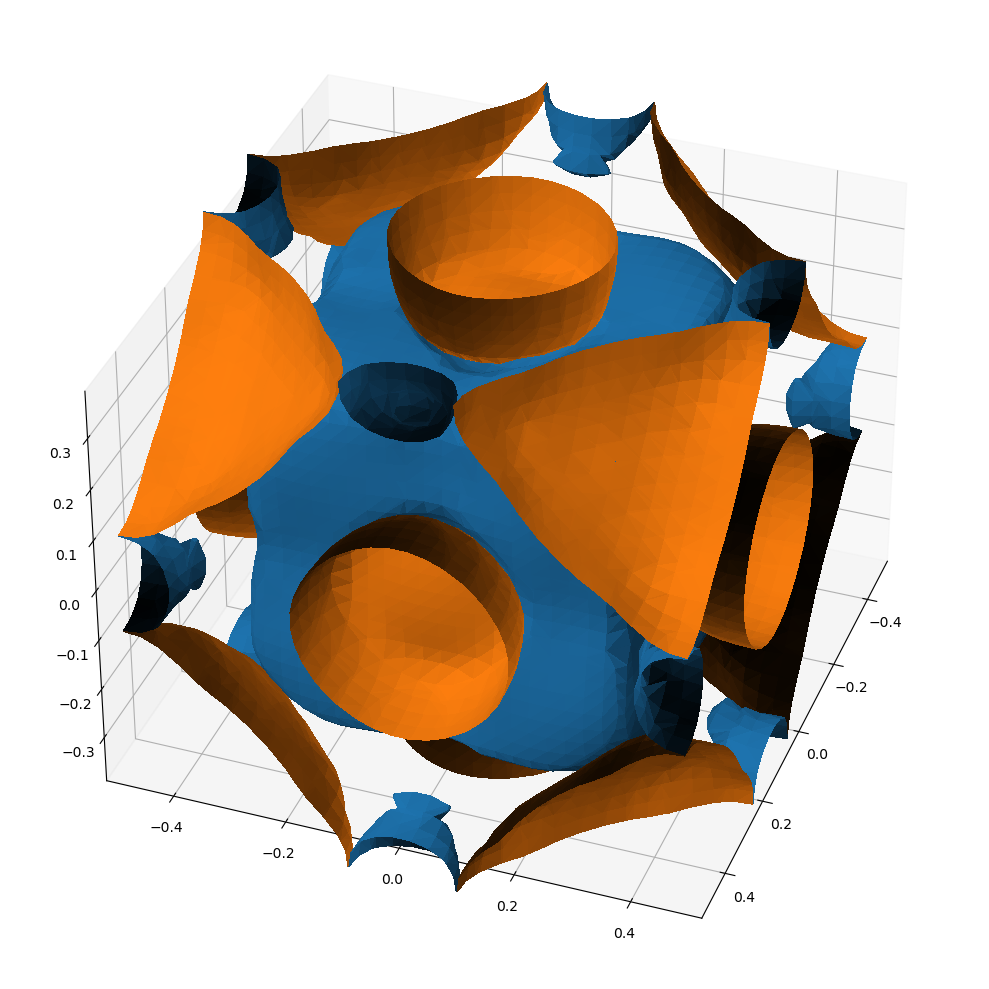

In [14]:
importlib.reload(fs)
# plot the fermi surface
fermi_energy = 16.157
fs.plot_3D_fermi_surface(tb_nitinol, fermi_energy, N=32)

In [15]:
# calculate conductivity (Czycholl page 269)
tau = 1e-15 # in s
elementary_charge = 1.602176634e-19 # in Coulomb
eV = elementary_charge # 1 eV in Joule
fermi_energy = 16.157 # in eV
T = 300
kB = 8.61733326214518e-5 # in eV/K
beta = 1 / (kB * T) # in 1/eV
alat = 2.993e-10 # m
hbar = 1.05457181764616e-34 # in SI J*s
k_unit = np.pi/2/alat # 1/m
def fermi(x):
    #return 1 / (1 + np.exp(x))
    return (np.tanh(-0.5 * x) + 1) * 0.5
def dfermi(x): # ~ exp(-x*x/5)/4
    #e = np.exp(x)
    #return -1 / (e + 2 + 1/e)
    return -0.25 / np.cosh(0.5 * x)**2
N = 20
k_smpl = np.meshgrid(np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False))
k_smpl += np.random.random(np.shape(k_smpl)) * ((1 - 0) / N) # this improves the integral a lot because it breaks symmetry -> *len(sym_group) integration sites
k_smpl = np.stack(k_smpl, axis=-1).reshape(-1, 3)
bands, grads = tb_nitinol.bands_grad(k_smpl)
v = grads * (eV / k_unit / hbar) # in m/s
#print(np.mean(np.mean(np.abs(v), axis=0), axis=1))
#print(np.mean(v)/np.mean(np.abs(v))) # this should be 0 for perfect sampling
# simplest integral formula
data = np.einsum("iaj,ibj,ij->iab", v, v, -dfermi((bands - fermi_energy) * beta))
I = np.mean(data, axis=0) # result is m^2/s^2
err = np.std(data, axis=0) / len(data)**0.5
sigma = 2 * elementary_charge**2 * tau * (beta*I)/eV / alat**3 # result is in 1/(Ohm*m)
avg_sigma = np.trace(sigma)/3
print(f"{sigma/avg_sigma}*{avg_sigma:.3e}\nwith error\n{err/np.abs(I)*100}%")

[[ 1.026  0.017  0.016]
 [ 0.017  1.011 -0.009]
 [ 0.016 -0.009  0.963]]*1.154e+07
with error
[[  4.434 101.023 108.957]
 [101.023   4.043 194.979]
 [108.957 194.979   4.066]]%


In [16]:
sigma_ref = 1 / 8.2e-8 # 1/(Ohm*m) Austenit (sc)
print(f"{sigma_ref:.2e}")
sigma_ref = 1 / 7.6e-8 # 1/(Ohm*m) Martensite
print(f"{sigma_ref:.2e}")

1.22e+07
1.32e+07
